In [0]:
!pip install torch
!pip install torchvision

In [0]:
import os
import torch
from torch import nn

import torch.optim as optim
import numpy as np
import time
from collections import OrderedDict

import PIL
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data

- data from `torchvision` ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)) 
- [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip)
- The dataset is split into three parts, training and validation, and test (collected by other Pytorch Scholars)
- To use a pre-trained network, we'll need to make sure the input data is resized to 224x224 pixels as required by the networks.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. We'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# After executing the cell below, Drive files will be present in 
# "/content/drive/My Drive".
#!ls "/content/drive/My Drive"  --> to view all files in My Drive

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# set up proper Google Drive for each dataset
data_dir = os.getcwd() + '/drive/My Drive/data/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/google_test_data'

#check drive location
print(data_dir)

/content/drive/My Drive/data/flower_data


In [0]:
# Define your transforms for the training, validation and test datasets
data_transforms = {
    'train_data': transforms.Compose([
            transforms.RandomAffine(45, translate=(0.1, 0.1), 
                                    scale=(1.0, 1.5), shear=None, 
                                    resample=PIL.Image.BILINEAR, fillcolor=0),
            transforms.Resize(256, interpolation=PIL.Image.HAMMING),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
            ])
            ,
    'valid_data': transforms.Compose([
            transforms.Resize(256, interpolation=PIL.Image.HAMMING),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
            ])
            ,
    'test_data': transforms.Compose([
            transforms.Resize(256, interpolation=PIL.Image.HAMMING),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
            ])
    }

# Load the datasets with ImageFolder
image_datasets = {
    'train': datasets.ImageFolder(train_dir
                                  , transform=data_transforms['train_data'])
    ,
    'valid': datasets.ImageFolder(valid_dir
                                  , transform=data_transforms['valid_data'])
    ,
    'test': datasets.ImageFolder(test_dir
                                 , transform=data_transforms['test_data'])
    }


In [0]:
# Create dataloaders with specific batch size
batch_size = 64

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], 
                    batch_size=batch_size, shuffle=True)
    ,
    'valid': torch.utils.data.DataLoader(image_datasets['valid'],
                    batch_size=batch_size, shuffle=True)
    ,
    'test': torch.utils.data.DataLoader(image_datasets['test'],
                    batch_size=batch_size, shuffle=True)
    }

In [0]:
# check image data loaded correctly
print("Number of training images: ", len(image_datasets['train']))
print("Number of validation images: ", len(image_datasets['valid']))
print("Number of test images: ", len(image_datasets['test']))

Number of training images:  6552
Number of validation images:  818
Number of test images:  995


In [0]:
#Change PIL version to run smoothly on Colab
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

    100% |████████████████████████████████| 5.6MB 7.4MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
#Sanity check for batch and tensor size
train_iter = iter(dataloaders['train'])
print(type(train_iter))

images, labels = train_iter.next()
print(images.shape, labels.shape)

<class 'torch.utils.data.dataloader._DataLoaderIter'>
torch.Size([64, 3, 224, 224]) torch.Size([64])


## Label mapping

- need to load in a mapping from category label to category name
- file `cat_to_name.json`
- JSON object read in with the [`json` module](https://docs.python.org/2/library/json.html)
- dictionary mapping the integer encoded categories to the actual names of the flowers

In [0]:
import json

with open('/content/drive/My Drive/data/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [17]:
#Sanity check for Label Mapping
cat_to_name['1']

'pink primrose'

# Building and training the classifier

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters
* Try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model
* Save  hyperparameters to use as default values in the next part of the project

In [10]:
#Create dictionary with many different pre-trained networks to test
pt_networks = {'alexnet': models.alexnet(pretrained=True),
              'vgg19': models.vgg19(pretrained=True),
              'resnet': models.resnet152(pretrained=True) ,
              'squeezenet' :models.squeezenet1_0(pretrained=True),
              'densenet': models.densenet161(pretrained=True),
              'inception': models.inception_v3(pretrained=True)}

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
244418560it [00:12, 19250245.55it/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:09, 63247671.33it/s]
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:15, 15908303.95it/s]
/usr/local/lib/python3.6/dist-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/usr/local/lib/python3.6/dist-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.torch/models/squeezenet1_0-a815701f.pt

In [0]:

#Define the network parameters
network = 'resnet'
input_feat = pt_networks[network].fc.in_features
output_feat = 102
hidden_1 = 1000
hidden_2 = 1000
dropout = 0.1

#Build a Classifier and attach to Pretrained model
def build_model(pretrained = 'alexnet',input_features = 10000, \
                output_features = 102, hidden_1 = 2000, \
               hidden_2 = 1000 ,p_dropout = 0.5):
  ''' Build a model using a pre-trained network with a custom
      Classifier of 3 linear layers and dropout and ReLU
      activation on each layer
      Input = pre-trained model type, '''
  #start with a pretrained network
  model = pt_networks[pretrained]

  #Freeze weights for pretrained layers
  for param in model.parameters():
    param.requires_grad = False
  
  # Build Classifier for model
  classifier = nn.Sequential(OrderedDict([
    ('dropout1', nn.Dropout(dropout)),
    ('fc1', nn.Linear(input_features, hidden_1)),
    ('relu1', nn.ReLU(inplace=True)),
    ('dropout2', nn.Dropout(dropout)),
    ('fc2', nn.Linear(hidden_1, hidden_2)),
    ('relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(hidden_2, output_features))
    ]))

  model.fc = classifier
    
  return model


#build the pre-trained model for training
model_pt = build_model(network, input_feat, output_feat,
                      hidden_1 = hidden_1, hidden_2 = hidden_2,
                      p_dropout = dropout)

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
#Train the Pre-trained network on 'flower_data/train'
#Define the hyperparameters - learning rate, # epochs
learning_rate = 0.003
epochs = 50
#Initialize lists for analysis tools
train_loss_list = []
valid_loss_list = []
acc_list = []
valid_loss_min = np.Inf

#NOTE - many optimizers because many iterations to find best option

#Define the loss function, optimizer, number of epochs
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model_pt.fc.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(model_pt.classifier.parameters(), lr=learning_rate
#                            , momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.35
#                                      , last_epoch=-1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
#               factor=0.35, patience=1, verbose=False, threshold=0.01, 
#               threshold_mode='rel', cooldown=0, min_lr=0.000001, eps=1e-08)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)

#Move model to GPU if available
if train_on_gpu:
  model_pt.cuda()

#Loop through number of epochs
for epoch in range(1, epochs+1):
  #start timer
  start = time.time()
  #Initialize training and validation and accuracy
  train_loss = 0.0
  valid_loss = 0.0
  accuracy = 0.0
  
  #increment the scheduler each epoch
  scheduler.step()
  
  #TRAINING
  model_pt.train()
  #Training Loop
  for batch_idx, (images, labels) in enumerate(dataloaders['train']):

    #move images and labels to GPU if available
    if train_on_gpu:
      images, labels = images.cuda(), labels.cuda()

    #zero out gradients
    optimizer.zero_grad()  
    output = model_pt(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()*images.size(0)
  
  #VALIDATION
  #Validation loop and print
  # Put model in eval mode and turn off gradients
  with torch.no_grad():
    model_pt.eval()
    for batch_idx, (images, labels) in enumerate(dataloaders['valid']):
      #move images and labels to GPU if available
      if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
      
      logits = model_pt(images)
      loss = criterion(logits, labels)
      valid_loss += loss.item()*images.size(0)
      
      #calculate accuracy - get predictions from softmax
      preds = nn.functional.softmax(logits, dim=1)
      #get top prediction for each image
      top_p, top_class = preds.topk(1, dim=1)
      #determine if precitions are correct
      equals = top_class == labels.view(*top_class.shape)
      #get accuracy
      accuracy += torch.sum(equals).item()
  
  #get average losses & accuracy for each epoch
  train_loss = train_loss/len(dataloaders['train'].dataset)
  valid_loss = valid_loss/len(dataloaders['valid'].dataset)
  accuracy = accuracy/len(dataloaders['valid'].dataset)
  #build loss_lists for plotting
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)
  acc_list.append(accuracy)

                                      
#   step for ReduceOnPlateau scheduler
#   scheduler.step(valid_loss)
 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \
        \tRun Time: {:.2f}'.format(epoch, train_loss, \
                                         valid_loss, (time.time() - start)))
  print("Validation Accuracy: {:.3f}".format(accuracy))
  
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
          .format(valid_loss_min, valid_loss))
    torch.save(model_pt.state_dict(), data_dir + 'temp_best_model.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.157787 	Validation Loss: 1.678680         	Run Time: 1934.81
Validation Accuracy: 0.512
Validation loss decreased (inf --> 1.678680).  Saving model ...
Epoch: 2 	Training Loss: 1.464476 	Validation Loss: 0.847410         	Run Time: 347.11
Validation Accuracy: 0.763
Validation loss decreased (1.678680 --> 0.847410).  Saving model ...
Epoch: 3 	Training Loss: 1.041155 	Validation Loss: 0.741881         	Run Time: 344.79
Validation Accuracy: 0.787
Validation loss decreased (0.847410 --> 0.741881).  Saving model ...
Epoch: 4 	Training Loss: 0.886622 	Validation Loss: 0.680280         	Run Time: 345.93
Validation Accuracy: 0.806
Validation loss decreased (0.741881 --> 0.680280).  Saving model ...
Epoch: 5 	Training Loss: 0.795965 	Validation Loss: 0.583834         	Run Time: 343.48
Validation Accuracy: 0.845
Validation loss decreased (0.680280 --> 0.583834).  Saving model ...
Epoch: 6 	Training Loss: 0.713938 	Validation Loss: 0.618000         	Run Time: 333.51
Va

##  Evaluate Loss Functions vs Epochs 

In [0]:
plt.plot(train_loss_list, label='Training loss')
plt.plot(test_loss_list, label='Validation loss')
plt.legend(frameon=False)

NameError: ignored

## Model Accuracy Function

In [0]:
# Check model accuracy on the Validation or Test dataset
def model_accuracy(model, data = dataloaders['valid']):
  ''' Get accuracy of a model tested on the validation data
  Input = trained model and dataset to test classification on
  Ouput = classification accuracy on the test set'''
  
  #move model to GPU if available
  if torch.cuda.is_available():
    model.cuda()
    
  accuracy = 0.
  
  # Put model in eval mode and turn off gradients
  with torch.no_grad():
    model.eval()
    for batch_idx, (images, labels) in enumerate(data):
      #move images and labels to GPU if available
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
      
      logits = model(images)
      
      #calculate accuracy - get predictions from softmax
      preds = nn.functional.softmax(logits, dim=1)
      #get top prediction for each image
      top_p, top_class = preds.topk(1, dim=1)
      #determine if precitions are correct
      equals = top_class == labels.view(*top_class.shape)
      #get accuracy
      accuracy += torch.sum(equals).item()

  print("Test Accuracy: {:.3f}".format(accuracy/len(data.dataset)))

#Run the model against test images
model_accuracy(model_pt)

Test Accuracy: 0.940


## Save the checkpoint

* Save the model for making predictions later. Must include every parameter needed to rebuild model from scratch.
* Need to save the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`
* Attach this to the model as an attribute which makes inference easier later on.
 ```model.class_to_idx = image_datasets['train'].class_to_idx```
* Save the optimizer state, `optimizer.state_dict`

In [0]:
# Save the checkpoint 
model_pt.class_to_idx = image_datasets['train'].class_to_idx

#use full path --> save to Google Drive
checkpoint_path = data_dir + '/resnet152_fc3_Step_Adam_epoch_50_best.pt'

checkpoint = {'pretrain_type': 'resnet',
              'learning_rate': learning_rate,
              'lr_schedule': ['SteplLR', 'step_size=7','gamma=0.35'
                              ,'50 epochs run'],
              'epochs': epochs,
              'input_size': input_feat,
              'output_size': output_feat,
              'hidden_1': hidden_1,
              'hidden_2': hidden_2,
              'dropout': dropout,
              'state_dict': model_pt.state_dict(),
              'optimizer': optimizer.state_dict(),
              'class_to_idx': model_pt.class_to_idx}

torch.save(checkpoint, checkpoint_path)

## Loading the checkpoint

In [0]:
# Repeat of previous function for convenience 
def build_model(pretrained = 'alexnet',input_features = 10000, \
                output_features = 102, hidden_1 = 2000, \
               hidden_2 = 1000 ,p_dropout = 0.5):
  ''' Build a model using a pre-trained network with a custom
  Classifier of 3 linear layers and dropout and ReLU
  activation on each layer'''
  #start with a pretrained network
  model = pt_networks[pretrained]

  #Freeze weights for pretrained layers
  for param in model.parameters():
    param.requires_grad = False
  
  # Build Classifier for model
  classifier = nn.Sequential(OrderedDict([
    ('dropout1', nn.Dropout(p_dropout)),
    ('fc1', nn.Linear(input_features, hidden_1)),
    ('relu1', nn.ReLU(inplace=True)),
    ('dropout2', nn.Dropout(p_dropout)),
    ('fc2', nn.Linear(hidden_1, hidden_2)),
    ('relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(hidden_2, output_features))
    ]))

  model.fc = classifier
    
  return model

In [0]:
def load_checkpoint(checkpoint_path):
  '''Input =  filepath of stored checkpoint
  Output = Pytorch classification model'''
  #load checkpoint from google drive storage
  checkpoint = torch.load(checkpoint_path, map_location=lambda storage
                          , loc: storage)
  
  model = build_model(checkpoint['pretrain_type'], checkpoint['input_size'], 
                           checkpoint['output_size'], checkpoint['hidden_1'],
                           checkpoint['hidden_2'], p_dropout=0.1)
  
  model.load_state_dict(checkpoint['state_dict'])
  
  model.class_to_idx = checkpoint['class_to_idx']

  return model

#load the saved model
checkpoint_path = data_dir + '/resnet152_fc3_Step_Adam_epoch_50_best.pt'
model_pt = load_checkpoint(checkpoint_path)

# Inference for classification

* Create a function to use a trained network for inference. 
* Write a function  `predict` that takes an image and a model, 
then returns the top $K$ most likely classes along with the probabilities. It should look like: 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

## Image Preprocessing

* Use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html))
* Write a function that preprocesses the image so it can be used as input for the model
* Function should process the images in the same manner used for training. 

In [0]:
def process_image(image_path, size = 224):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model
        Input = path to image file
        Output = Numpy array of image file formatted for Pytorch
    '''
    #load image and examine details
    im = Image.open(image_path)
    #print(im.format, im.size, im.mode)
      
    if im.size[0] > im.size[1]:
      im.thumbnail((10000, 256))
    else:
      im.thumbnail((256, 10000))
      
    #define (left,top) and (right,bottom) corner for image cropping
    left = (im.width - size)/2
    top = (im.height - size)/2
    right = (im.width + size)/2
    bottom = (im.height + size)/2
    im = im.crop((left, top, right, bottom))

    # turn image into an array
    np_image = np.array(im)/255

    #Normalize np_array the same as pre-trained networks
    #define the pre-trained mean and standard deviations
    means = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - means)/std

    #transpose np_image to put the color channel first for Pytorch
    np_image = np_image.transpose((2,0,1))
   
    return np_image

In [0]:
def imshow(image, ax=None, title=None):
    """Takes a processed image file and convert it back into an image
    Input= numpy array of processed image file
    Output = view of original image file"""      
    
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Clip Image between 0-1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

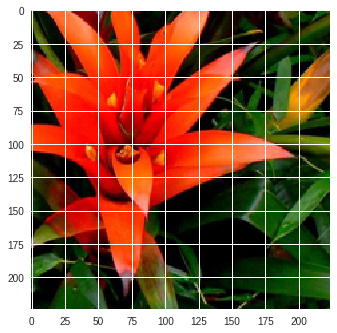

In [14]:
#Sanity check for image processing functions

# process an image file
test_image = process_image(data_dir + '/valid/99/image_07860.jpg')
imshow(test_image)


## Class Prediction
* Write a function for making predictions pre-trained Pytorch model. 
* Predict the top 5 most probable classes.

In [0]:
def predict(image_path, model, topk=5):
  ''' Predict the class (or classes) of an image using a trained deep learning 
  model. 
  Input = file path to image file, Pytorch classification mode, number of 
  top classifications to view
  Output = top n class predictions, top n flower name predcitions, pobability
  for top n predictions'''
    
  # Implement the code to predict the class from an image file
  model.eval()
  np_image = process_image(image_path)
  
  #convert numpy --> tensor
  image_tensor = torch.from_numpy(np_image).type(torch.FloatTensor)
  #add batch size  = 1 to tensor
  image_tensor = image_tensor.unsqueeze(0)
  
  image_tensor.to('cpu')
  model.to('cpu')

  with torch.no_grad():
    logits = model_pt(image_tensor)

  preds = nn.functional.softmax(logits, dim=1)
  #get top prediction for each image
  top_p, top_class = preds.topk(5, dim=1)

  top_p = top_p.cpu().detach().numpy().tolist()[0]
  top_class = top_class.cpu().detach().numpy().tolist()[0]
  
  idx_to_class = {val: key for key, val in
                model.class_to_idx.items()}
  top_class = [idx_to_class[x] for x in top_class]
  top_flowers = [cat_to_name[x] for x in top_class]

  return top_p, top_class, top_flowers

#Get prediction for test image
test_image = data_dir + '/valid/99/image_07860.jpg'
top_p, top_class, top_flowers = predict(test_image, model_pt)


## Sanity Checking

Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

* convert from the class integer encoding to actual flower names with the `cat_to_name.json` file 
* use the `predict` and `process_image` and `imshow` functions defined above.

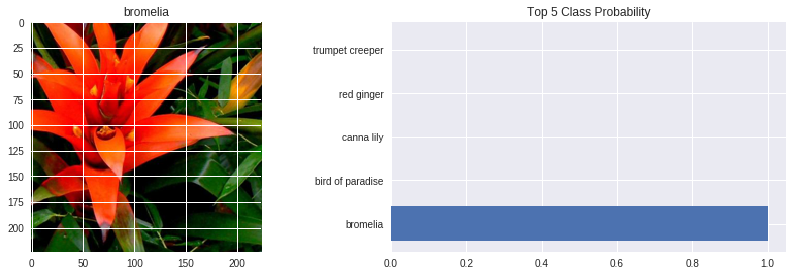

In [24]:
def view_classify(img_path):
  ''' Function for viewing an image and it's predicted classes.
  Input = filepath to image
  Output = plot of formatted image next to bar graph of top 5 predicted flower 
  classes with respective probabilities 
  '''
  plt.figure(figsize=(12, 4))
  ax = plt.subplot(1, 2, 1)
  # Set up title
  flower_num = img_path.split('/')[7]
  title_ = cat_to_name[flower_num]
  # Plot flower
  img = process_image(img_path)
  imshow(img, ax, title=title_)
  # Make prediction
  probs, labs, flowers = predict(img_path, model_pt)
  plt.subplot(1, 2, 2)
  #sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
  plt.barh(np.arange(5), probs)
  plt.yticks(np.arange(5), flowers, size = 'small')
  plt.title('Top 5 Class Probability')
  plt.tight_layout()
  plt.show()

# Test view_classify function with test_image from validation data    
test_image = data_dir + '/valid/99/image_07860.jpg'
view_classify(test_image)